<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/StockPredTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [5]:
!pip install yfinance

In [0]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime as dt
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas_datareader.data  as pdr
from tqdm.auto import tqdm
import yfinance as yf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 6]


In [0]:
training_days = 30
total_years = 15
total_dates = total_years * 365

In [8]:
ticker = 'AAPL'
valid_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = training_days
stocks_intradays = pdr.get_data_yahoo(ticker, dt.date.today() - dt.timedelta(total_dates), dt.date.today() - dt.timedelta(60))
stocks_innerdays = yf.download(tickers=ticker, period="60d", interval="2m")
stocks = pd.concat([stocks_intradays, stocks_innerdays], sort=True)


[*********************100%***********************]  1 of 1 completed


In [9]:
display(stocks)

,Adj Close,Close,High,Low,Open,Volume
2005-03-10 00:00:00,4.939153,5.690000,5.751429,5.585714,5.647143,194277300.0
2005-03-11 00:00:00,4.993715,5.752857,5.798572,5.685714,5.744286,158207700.0
2005-03-14 00:00:00,4.999917,5.760000,5.827143,5.645714,5.788571,151346300.0
2005-03-15 00:00:00,5.079279,5.851429,5.877143,5.750000,5.805714,127152200.0
2005-03-16 00:00:00,5.106561,5.882857,6.044286,5.825714,5.887143,174453300.0
...,...,...,...,...,...,...
2020-03-06 10:08:00-05:00,285.313995,285.313995,286.070007,284.929993,285.274994,266330.0
2020-03-06 10:10:00-05:00,286.070007,286.070007,286.309204,284.790009,285.309998,300138.0
2020-03-06 10:12:00-05:00,286.769989,286.769989,287.079987,285.619995,286.045013,355536.0
2020-03-06 10:14:00-05:00,287.144989,287.144989,287.279999,286.609314,286.800995,236154.0


In [0]:
stocks = stocks.rename(str.lower, axis='columns')
stocks.dropna(inplace=True)

In [11]:
def normalize_data(stocks_df):
    df = stocks_df.copy()
    features = ['volume', 'open', 'high', 'low', 'close', 'adj close']
    min_max_scaler = None
    for feature in features:
        min_max_scaler = sklearn.preprocessing.MinMaxScaler()
        df[feature] = min_max_scaler.fit_transform(df[feature].values.reshape(-1, 1))
    return df, min_max_scaler

stocks_scaled, close_scaler = normalize_data(stocks)
display(stocks_scaled.head(5))

,adj close,close,high,low,open,volume
2005-03-10 00:00:00,0.002185,0.002522,0.002226,0.002650,0.002358,0.230393
2005-03-11 00:00:00,0.002354,0.002717,0.002372,0.002960,0.002659,0.187618
2005-03-14 00:00:00,0.002373,0.002739,0.002460,0.002836,0.002796,0.179481
2005-03-15 00:00:00,0.002618,0.003022,0.002615,0.003159,0.002850,0.150790
2005-03-16 00:00:00,0.002703,0.003120,0.003133,0.003394,0.003102,0.206884


In [12]:
def load_data(scaled_df, seq):
    data_raw = scaled_df.values
    data = []
    for index in range(len(data_raw) - seq):
        data.append(data_raw[index: index + seq])
    data = np.array(data)
    valid_size = int(valid_set_size_percentage/100*data.shape[0])
    test_size = int(test_set_size_percentage/100*data.shape[0])
    train_size = len(data) - valid_size - test_size
    x_train = data[:train_size, :-1, :-1]
    y_train = data[:train_size,  -1, :-1]
    
    x_valid = data[train_size: train_size + valid_size, :-1, :-1]
    y_valid = data[train_size: train_size + valid_size,  -1, :-1]
    
    x_test  = data[train_size + valid_size:, :-1, :-1]
    y_test  = data[train_size + valid_size:,  -1,  :-1]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(stocks_scaled, seq_len)
print ('x_train.shape:', x_train.shape)
print ('y_train.shape:', y_train.shape)
print ('x_valid.shape:', x_valid.shape)
print ('y_valid.shape:', y_valid.shape)
print (' x_test.shape:', x_test.shape)
print (' y_test.shape:', y_test.shape)

x_train.shape: (8281, 29, 5)
y_train.shape: (8281, 5)
x_valid.shape: (1035, 29, 5)
y_valid.shape: (1035, 5)
 x_test.shape: (1035, 29, 5)
 y_test.shape: (1035, 5)


In [0]:
index_in_epoch = 0
perm_array = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array)
    start = 0
    index_in_epoch += batch_size
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [0]:
def run_model(x_test_data):
    n_steps = seq_len - 1
    n_inputs = 5
    n_neurons = 200
    n_outputs = 5
    n_layers = 2
    learining_rate = 0.001
    batch_size = 50
    n_epoch = 20
    train_set_size = x_train.shape[0]
    test_set_size = x_test_data.shape[0]
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_outputs])

    #RNN
    layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]

    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
    outputs = outputs[:,n_steps-1,:]

    loss = tf.reduce_mean(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learining_rate)
    training_op = optimizer.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for iteration in range(int(n_epoch*train_set_size/batch_size)):
            x_batch, y_batch = get_next_batch(batch_size)
            sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
            if iteration % int(5*train_set_size/batch_size) == 0:
                mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
                mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
                print ('%.2f epochs: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train, mse_valid))
        #y_test_pred = sess.run(outputs, feed_dict={X: x_test})
        pred = sess.run(outputs, feed_dict={X: x_test_data})
    return pred

In [15]:
y_pred = run_model(x_test)
x_test_new = np.concatenate((x_test[:, 1:, :], y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])), axis=1)
y_pred_new = run_model(x_test_new)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for upd

(1035, 5)


,target,predict,predict_new,target_ret,predict_ret,predict_new_ret,predict_ret_gold,success,success_ret
1,279.286025,280.702820,283.424561,-0.001256,0.000024,0.009627,0.009667,0,0.000000
2,278.885253,280.617981,283.442963,-0.001437,-0.000302,0.009667,0.009299,0,0.000000
3,279.436311,280.517059,283.251831,0.001972,-0.000360,0.009299,0.009573,1,0.001972
4,279.366167,280.498169,283.228363,-0.000251,-0.000067,0.009573,0.009578,0,0.000000
5,279.195854,280.443695,283.210724,-0.000610,-0.000194,0.009578,0.009719,0,0.000000
...,...,...,...,...,...,...,...,...,...
1029,285.437977,285.509338,288.255615,0.000562,0.002131,0.011638,0.011567,1,0.000562
1030,284.906917,286.076111,288.850342,-0.001864,0.001981,0.011567,0.010698,0,0.000000
1031,284.977060,286.345856,289.169647,0.000246,0.000942,0.010698,0.009374,1,0.000246
1032,284.836804,286.369995,289.055328,-0.000492,0.000084,0.009374,0.009128,0,0.000000


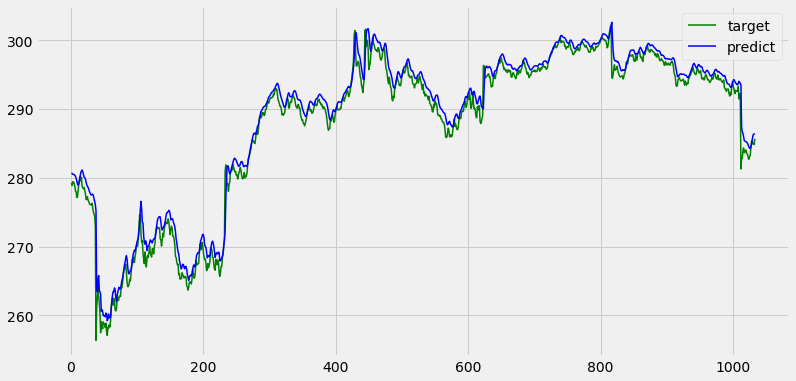

Success Rate:50.14520813165537
Success Rate Ret:0.0020279742028347383


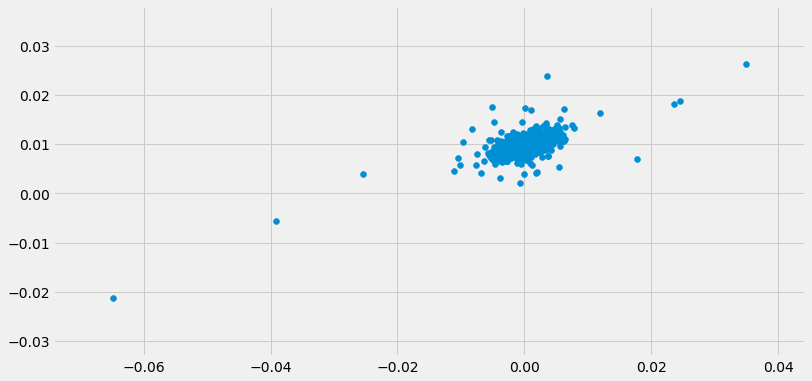

In [16]:
print(y_test.shape)
result = pd.DataFrame()
result['target'] = close_scaler.inverse_transform(y_test[:,3].reshape(-1, 1))[:,0]
result['predict'] = close_scaler.inverse_transform(y_pred[:,3].reshape(-1, 1))[:,0]
result['predict_new'] = close_scaler.inverse_transform(y_pred_new[:,3].reshape(-1, 1))[:,0]
result['target_ret'] = (result.target - result.target.shift(1)) / result.target
result['predict_ret'] = (result.predict - result.predict.shift(1)) / result.predict
result['predict_new_ret'] = (result.predict_new - result.predict.shift(1)) / result.predict_new
result['predict_ret_gold'] = result.predict_new_ret.shift(-1)
result.dropna(inplace=True)
result['success'] = ((result.target_ret * result.predict_ret_gold) > 0).astype(np.int)
result['success_ret'] = np.abs(result.target_ret * result.success)
display(result)
plt.plot(result.target, linewidth=1.5, label='target', c='g')
plt.plot(result.predict, linewidth=1.5, label='predict', c='b')
plt.legend()
plt.show()

print("Success Rate:{}".format(result.success.sum() * 100 / (y_test.shape[0] - 2)))
print("Success Rate Ret:{}".format(result.success_ret.sum() / result.success.sum()))
plt.scatter(result.target_ret, result.predict_ret_gold)
plt.show()
